# Модель предсказания коэффициента восстановления золота из золотосодержащей руды

In [22]:
#pip install -U scikit-learn --user

# 1. Подготовка данных

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, TimeSeriesSplit, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState

#### 1.1. Откройте файлы и изучите их.

In [102]:
data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')
print(data_train.shape)
print(data_test.shape)
print(data_full.shape)

(16860, 87)
(5856, 53)
(22716, 87)


In [103]:
data_train.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


In [104]:
data_test.head(3)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [105]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

На вход нам даны 3 датасета - тестовая и обучающая выборки, и датасет с общими данными. Все они имеют разные размеры. Некоторые параментры осутствуют (всего 87 признаков-столбцов), исходя из того, что они рассчитываются позднее. В тестовой выборке наблюдаем отсутствие некоторых признаков, которые имеются в обучающей выборке. В тестовом наборе нет целевых признаков.

#### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery Найдите МАЕ между вашими расчётами и значением признака. Опишите выводы.

In [106]:
def eff(C, F, T):
    res = (C*(F-T)) / (F*(C-T)) * 100
    res[res<0] = np.nan
    res[res>100] = np.nan
    return res

c = data_train['rougher.output.concentrate_au']
f = data_train['rougher.input.feed_au']
t = data_train['rougher.output.tail_au']
recovery = eff(c, f, t)
right_recovery_sum = np.isclose(data_train['rougher.output.recovery'], recovery).sum()
right_recovery_sum, data_train.shape[0]-right_recovery_sum

(14287, 2573)

Совпало 14287 рассчетных с иходными, не совпало 2573, возможно там пропуски

In [107]:
columns = list(data_train.columns)
columns.remove('rougher.output.recovery')
columns.remove('final.output.recovery')
columns.remove('date')

imputer = KNNImputer()
data_train[columns] = imputer.fit_transform(data_train[columns])

print(data_train['rougher.output.recovery'].shape)
print(recovery.shape)
print(data_train['rougher.output.recovery'].isnull().sum())
print(recovery.isnull().sum())

(16860,)
(16860,)
2573
2573


In [108]:
recovery = recovery.dropna()
data_train = data_train.dropna(axis='index', how='any', subset=['rougher.output.recovery'])

mae = mean_absolute_error(recovery, data_train['rougher.output.recovery'])
mae

9.444891926100695e-15

MAE в данном случае измеряет среднюю величину ошибок между расчётами rougher.output.recovery по формуле и данными значениями признака без учета их направления. MAE на уровне примерно $9.44 \cdot 10^{-15}$ говорит о том, что эффективность обогащения рассчитана правильно.

#### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [109]:
set(data_train.columns) - set(data_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В data_test у нас нет признаков output, так как это целевые признаки. Так же в data_test нет признаков calculation для этапа rougher, как сказано в условии эти данные получаются в процессе производства, либо по его завершении.

#### 1.4.	Проведите предобработку данных.

В тестовую выборку добавим целевые признаки - столбцы rougher.output.recovery и final.output.recovery из data_full

In [110]:
data_full.set_index('date', inplace=True)
data_test.set_index('date', inplace=True)

data_test['rougher.output.recovery'] = data_full['rougher.output.recovery']
data_test['final.output.recovery'] = data_full['final.output.recovery']

Удалим пропуски в целевых признаках

In [111]:
data_test.dropna(subset=['rougher.output.recovery'], inplace=True)
data_test.dropna(subset=['final.output.recovery'], inplace=True)

data_full.dropna(subset=['rougher.output.recovery'], inplace=True)
data_full.dropna(subset=['final.output.recovery'], inplace=True)

data_train.dropna(subset=['rougher.output.recovery'], inplace=True)
data_train.dropna(subset=['final.output.recovery'], inplace=True)

Заполним пропуски в данных

In [112]:
data_test.reset_index(inplace = True)
columns = list(data_test.columns)
columns.remove('date')

imputer = KNNImputer(weights="distance")
data_test[columns] = imputer.fit_transform(data_test[columns])
data_train[columns] = imputer.fit_transform(data_train[columns])
data_full[columns] = imputer.fit_transform(data_full[columns])

# 2. Анализ данных

#### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

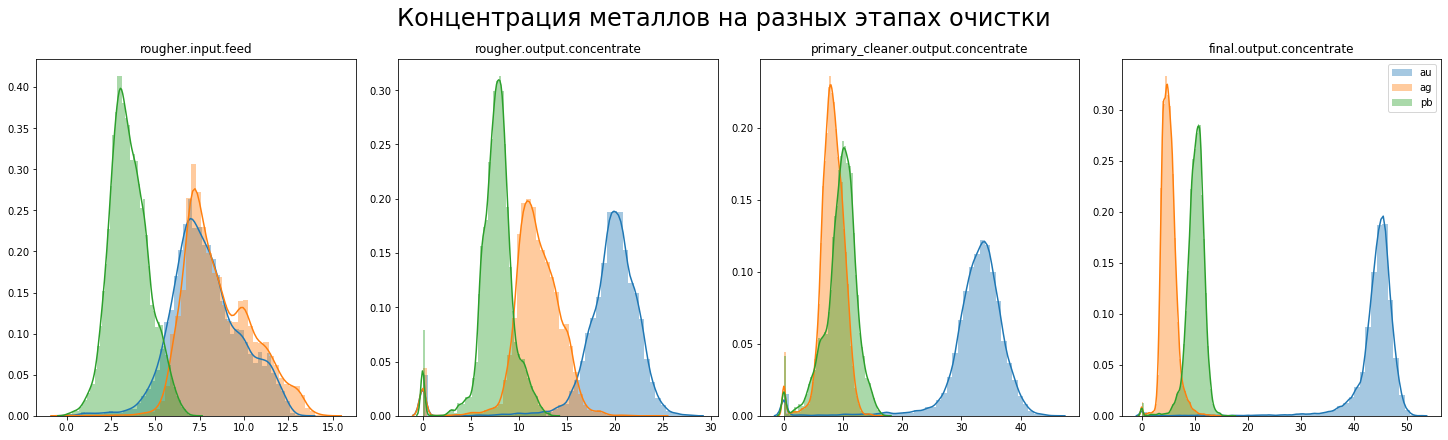

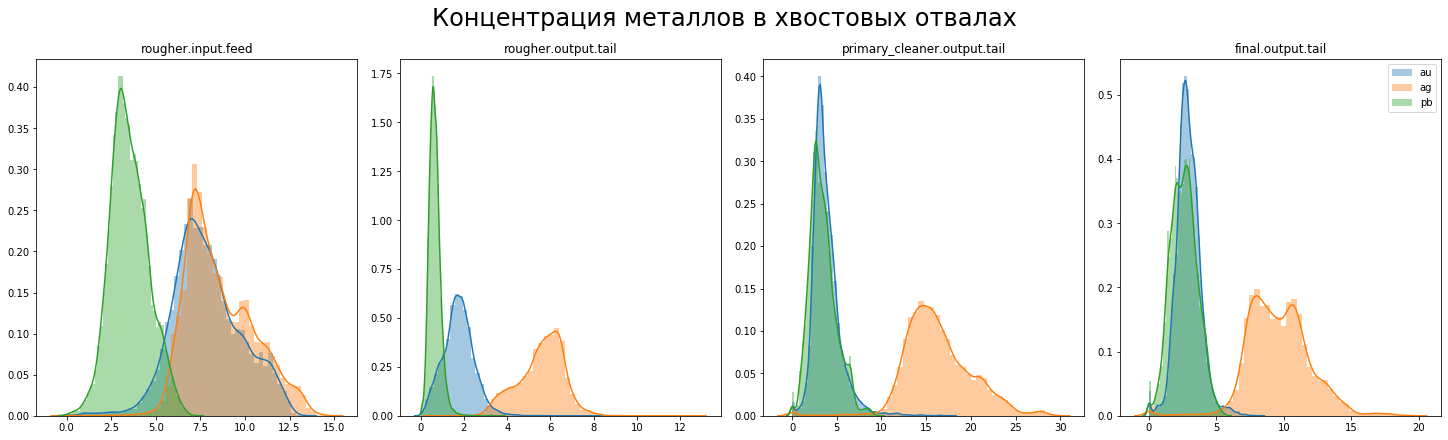

In [82]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

process_tail = ['rougher.input.feed',
                'rougher.output.tail',
                'primary_cleaner.output.tail',
                'final.output.tail']

metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов на разных этапах очистки', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = data_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(data_train.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвостовых отвалах', fontsize=24)

for stage, ax in zip(process_tail, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = data_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(data_train.loc[:, cols].dropna(), label=metal, ax=ax)   
plt.legend()

plt.show()

Анализируя графики изменения концентрации металлов на различных стадиях можно сделать следующие выводы:
* В процессе очистки концентрация золота увеличивается с 15 до 50 %, другие металлы - серебро и свинец сокращая свою долю.
* Наблюдается небольшая аномалия в значении 0. что говорит о том, что в данных есть выбросы.
* В хвостовых отвалах так же наблюдается различная концентрация металлов.
* Превалирующее значение в наблюдении за хвостовыми отвалами занимает серебро.

Посторим графики для концентрации металлов на разных процессах на выходе и в хвостовых отвалах:

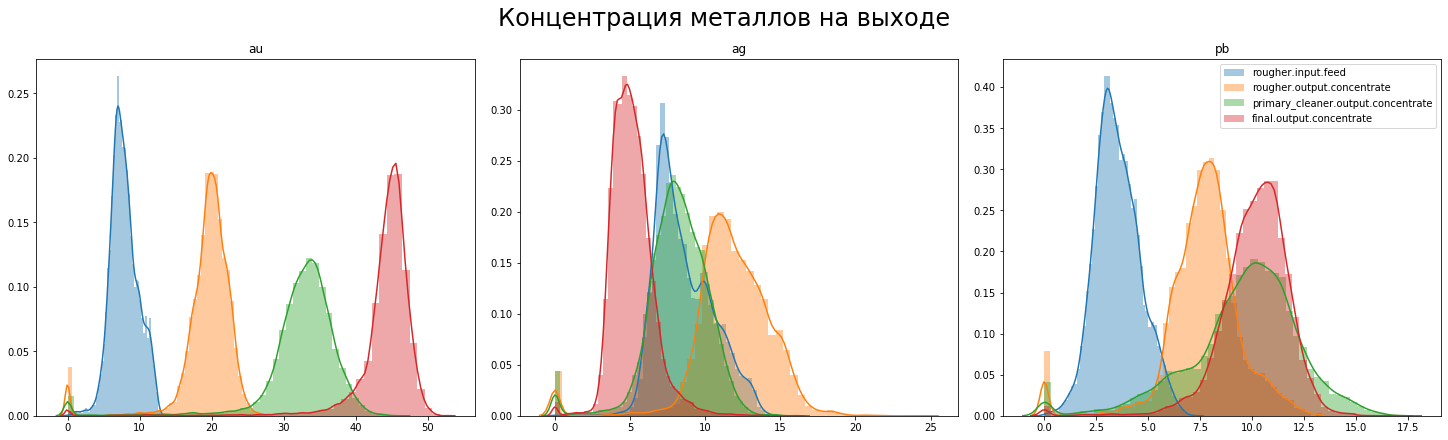

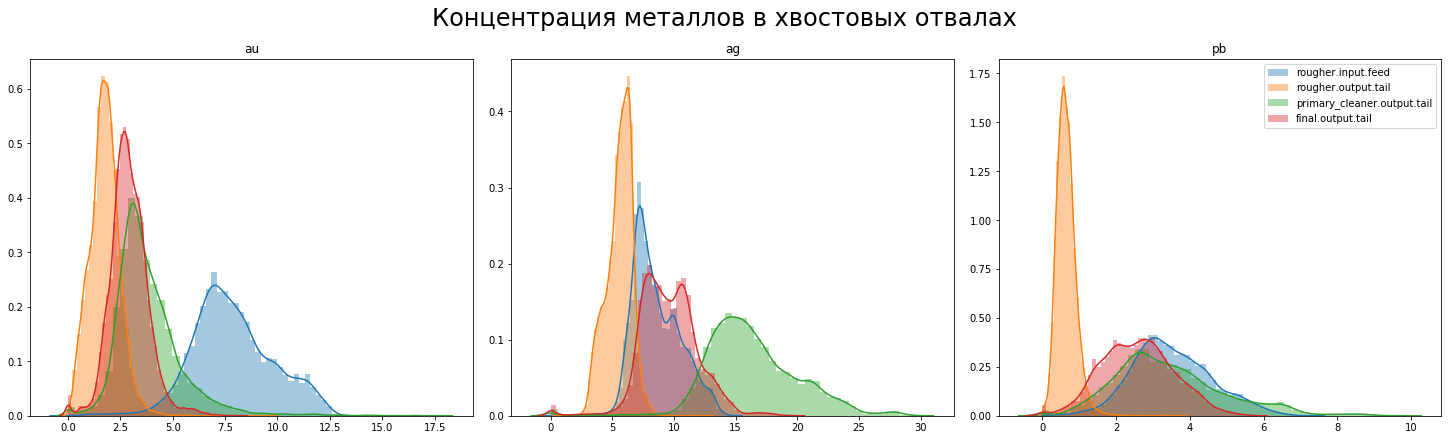

In [83]:
fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов на выходе', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:
        cols = data_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(data_train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвостовых отвалах', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process_tail:
        cols = data_train.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(data_train.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

plt.show()

Подтверждаем сделанные ранее выводы, что с каждым процессом очистки увеличивается концентрация золота. Менее значительным кажется рост концентрации серебра и свинца, но он так же наблюдается. Что касается отвалов в хвостах, то максимальная концентрация металлов здесь на этапе флотации, при очистке концентрация всех металлов снижается.

Концентрация серебра по мере прохождения технологического процесса обработки уменьшается. Концентрация серебра практически не изменяется на этапе флотации и первичной очистки и падает к финальному значению (после обработки). 

#### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

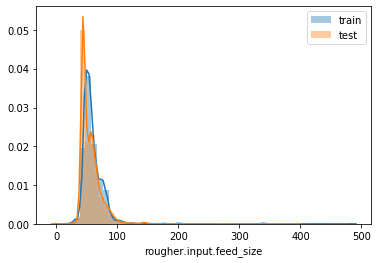

In [84]:
sns.distplot(data_train['rougher.input.feed_size'].dropna(), label='train')
sns.distplot(data_test['rougher.input.feed_size'].dropna(), label='test')
plt.legend()

Распределения размеров гранул сырья на обучающей и тестовой выборках практически идентичны. Что дает нам судить о том, что оценка модели будет правильной.

#### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок?

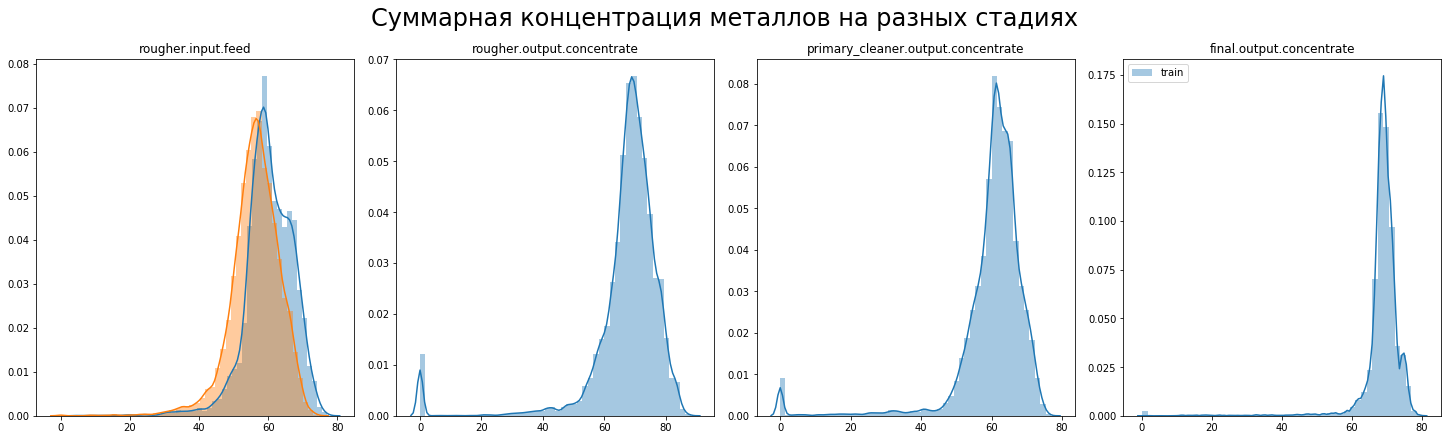

In [85]:
fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Суммарная концентрация металлов на разных стадиях', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    sum_train = data_train[stage+ '_ag'] + data_train[stage+ '_au'] + data_train[stage+ '_pb'] + data_train[stage+ '_sol']
    try:
        sum_test = data_test[stage+ '_ag'] + data_test[stage+ '_au'] + data_test[stage+ '_pb'] + data_test[stage+ '_sol']
        sns.distplot(sum_test, label='test', ax=ax)  ### зачем dropna? Пропуски уже удалены.
    except KeyError:
        pass
    sns.distplot(sum_train.dropna(), label='train', ax=ax)

plt.legend()
plt.show()

На этапе флотации в обучающей выборке наблюдается аномальное значение в суммарном распеределении, около нуля. Это может быть из-за проблем выгрузки, в осутствии необходимых данных.

In [113]:
data_train.drop(data_train[data_train['primary_cleaner.output.concentrate_ag'] == 0].index, inplace=True)
data_train.drop(data_train[data_train['primary_cleaner.output.concentrate_au'] == 0].index, inplace=True)
data_train.drop(data_train[data_train['primary_cleaner.output.concentrate_pb'] == 0].index, inplace=True)
data_train.drop(data_train[data_train['primary_cleaner.output.concentrate_sol'] == 0].index, inplace=True)

data_train.drop(data_train[data_train['rougher.output.concentrate_ag'] == 0].index, inplace=True)
data_train.drop(data_train[data_train['rougher.output.concentrate_au'] == 0].index, inplace=True)
data_train.drop(data_train[data_train['rougher.output.concentrate_pb'] == 0].index, inplace=True)
data_train.drop(data_train[data_train['rougher.output.concentrate_sol'] == 0].index, inplace=True)

# 3. Модель

#### 3.1. Напишите функцию для вычисления итоговой sMAPE.

In [114]:
def smape_end(target_rougher, predict_rougher, target_final, predict_final):
    smape_rougher = 100/len(target_rougher) * np.sum(2 * np.abs(predict_rougher - target_rougher) /
                                                     (np.abs(target_rougher) + np.abs(predict_rougher)))
    smape_final = 100/len(target_final) * np.sum(2 * np.abs(predict_final - target_final) /
                                                 (np.abs(target_final) + np.abs(predict_final)))
    return 0.25*(smape_rougher) + 0.75*(smape_final)

#### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [115]:
#data_test['rougher.output.recovery'] = data_full['rougher.output.recovery']
#data_test['final.output.recovery'] = data_full['final.output.recovery']

data_test.reset_index(drop=True, inplace=True)
data_train.reset_index(drop=True, inplace=True)
data_train.drop(['date'], axis='columns', inplace=True)
data_test.drop(['date'], axis='columns', inplace=True)

features_train_1 = data_train.drop(set(data_train.columns)-set(data_test.columns), axis=1).filter(regex='^rougher', axis=1)
features_train_1 = features_train_1.drop(['rougher.output.recovery'], axis=1)
target_train_1 = data_train['rougher.output.recovery']

features_train_2 = data_train.drop(set(data_train.columns)-set(data_test.columns), axis=1)
features_train_2 = features_train_2.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_2 = data_train['final.output.recovery']

features_test_1 = data_test.filter(regex='^rougher', axis=1)
features_test_1 = features_test_1.drop(['rougher.output.recovery'], axis=1)
target_test_1 = data_test['rougher.output.recovery']

features_test_2 = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_2 = data_test['final.output.recovery']

In [95]:
for estimator in range(10, 100, 10):
    for depth in range(1, 20, 3):
        model_1 = RandomForestRegressor(n_estimators=estimator, max_depth=depth, random_state=12345)
        y_pred_1 = cross_val_predict(model_1, features_train_1, target_train_1, cv = 3)
        y_pred_2 = cross_val_predict(model_1, features_train_2, target_train_2, cv = 3)
        smape = smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2)
        print("n_estimators =", estimator, "max_depth =", depth, "sMAPE =", smape)

n_estimators = 10 max_depth = 1 sMAPE = 10.703897553782841
n_estimators = 10 max_depth = 4 sMAPE = 10.847404813088994
n_estimators = 10 max_depth = 7 sMAPE = 11.419079262238737
n_estimators = 10 max_depth = 10 sMAPE = 11.40071656557987
n_estimators = 10 max_depth = 13 sMAPE = 11.49239258494457
n_estimators = 10 max_depth = 16 sMAPE = 11.603396454884532
n_estimators = 10 max_depth = 19 sMAPE = 11.599464884208425
n_estimators = 20 max_depth = 1 sMAPE = 10.735965495967557
n_estimators = 20 max_depth = 4 sMAPE = 10.878179573540159
n_estimators = 20 max_depth = 7 sMAPE = 11.012061311269933
n_estimators = 20 max_depth = 10 sMAPE = 11.210430835735314
n_estimators = 20 max_depth = 13 sMAPE = 11.151855186708323
n_estimators = 20 max_depth = 16 sMAPE = 11.30823988907571
n_estimators = 20 max_depth = 19 sMAPE = 11.17395450009249
n_estimators = 30 max_depth = 1 sMAPE = 10.789412710061818
n_estimators = 30 max_depth = 4 sMAPE = 10.892085954842077
n_estimators = 30 max_depth = 7 sMAPE = 10.761793504

Лучший подобранный гиперпараметр
 - n_estimators = 80 max_depth = 7 sMAPE = 10.581573673558193

In [96]:
for depth in range(1, 20, 1):
    model_2 = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    y_pred_1 = cross_val_predict(model_2, features_train_1, target_train_1, cv = 3)
    y_pred_2 = cross_val_predict(model_2, features_train_2, target_train_2, cv = 3)
    smape = smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2)
    print("max_depth =", depth, "sMAPE =", smape)

max_depth = 1 sMAPE = 11.088687204054228
max_depth = 2 sMAPE = 10.124861385422008
max_depth = 3 sMAPE = 10.598501059712483
max_depth = 4 sMAPE = 11.54422920855149
max_depth = 5 sMAPE = 10.97084714033736
max_depth = 6 sMAPE = 11.36977033591002
max_depth = 7 sMAPE = 12.077403596574223
max_depth = 8 sMAPE = 12.288434334629988
max_depth = 9 sMAPE = 13.401354732637254
max_depth = 10 sMAPE = 13.804360988891984
max_depth = 11 sMAPE = 14.553407751123956
max_depth = 12 sMAPE = 14.57214993378347
max_depth = 13 sMAPE = 14.641600390377878
max_depth = 14 sMAPE = 15.576560998990477
max_depth = 15 sMAPE = 15.577878668521915
max_depth = 16 sMAPE = 15.568189926536116
max_depth = 17 sMAPE = 15.958585867069733
max_depth = 18 sMAPE = 16.181181950303248
max_depth = 19 sMAPE = 15.88232877570172
-1.7564282412000987


Лучшие smape при гиперпараметрах max_depth = 2 sMAPE = 10.124861385422008

Значение smape лучше у модели случайного леса, будем ее  проверять на тестовой выборке.

In [117]:
#features_test_1.dropna(inplace=True)
#features_test_2.dropna(inplace=True)
#target_test_1.dropna(inplace=True)
#target_test_2.dropna(inplace=True)

#data_train = data_train.drop(set(data_train.columns)-set(data_test.columns), axis=1) 

model_test_1 = DecisionTreeRegressor(max_depth=2, random_state=12345)
model_test_2 = DecisionTreeRegressor(max_depth=2, random_state=12345)
model_test_1.fit(features_train_1, target_train_1)
model_test_2.fit(features_train_2, target_train_2)
pred_1 = pd.Series(model_test_1.predict(features_test_1))
pred_2 = pd.Series(model_test_2.predict(features_test_2))

smape_end(target_test_1, pred_1, target_test_2, pred_2)

9.380757282814496

По аналогии проверим модель на адекватность

In [118]:
from sklearn.dummy import DummyRegressor

dr_1 = DummyRegressor(strategy="mean")
dr_2 = DummyRegressor(strategy="mean")
dr_1.fit(features_train_1, target_train_1)
dr_2.fit(features_train_2, target_train_2)
pred_1 = pd.Series(dr_1.predict(features_test_1))
pred_2 = pd.Series(dr_2.predict(features_test_2))

smape_end(target_test_1, pred_1, target_test_2, pred_2)

9.956215298651959

Модель прошла проверку на адекватность так как smape модели по средним значением больше, чем на тестовой.